In [11]:
import numpy as np
from datasets import load_dataset
import torch
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import Trainer
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
from transformers import ViTForImageClassification, default_data_collator
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, feature_extractor):
        self.img_dir = img_dir
        self.img_labels = []
        self.img_files = []
        self.feature_extractor = feature_extractor
        self.label_mapping = {'REAL': 1, 'FAKE': 0}

        for label_dir in ['REAL', 'FAKE']:
            dir_path = os.path.join(img_dir, label_dir)
            files = os.listdir(dir_path)
            for file in files:
                self.img_files.append(os.path.join(dir_path, file))
                self.img_labels.append(self.label_mapping[label_dir])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels[idx]
        features = self.feature_extractor(images=image, return_tensors="pt")
        # Ensure the output is in a dictionary format
        return {"pixel_values": features['pixel_values'].squeeze(), "labels": torch.tensor(label)}




In [14]:
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
# device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=2
)
model.to(device)

# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# Create the dataset
train_dataset = CustomImageDataset(img_dir='AI_Human_Image_Classification/dataset/train', feature_extractor=feature_extractor)
test_dataset = CustomImageDataset(img_dir='AI_Human_Image_Classification/dataset/test', feature_extractor=feature_extractor)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
device

device(type='cuda')

In [18]:
from torch.optim import SGD
optimizer = SGD(model.parameters(), lr=5e-5)

In [19]:
from transformers import TrainerCallback

class LossHistory(TrainerCallback):
    "A callback that records eval loss into a list."
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # We extract the loss from the logs and record it
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

In [21]:
import logging
from transformers import set_seed, logging

logging.set_verbosity_info()
set_seed(42)

In [28]:
training_args = TrainingArguments(
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    num_train_epochs=4,
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    output_dir="./outputs",
    use_cpu=False,
    metric_for_best_model="loss",
    #bf16=True
)
loss_history = LossHistory()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
    compute_metrics=None,  # Define your metrics function if needed
    optimizers = (optimizer, None),
    callbacks=[loss_history]
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [29]:
trainer.train()

***** Running training *****
  Num examples = 100,000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25,000
  Number of trainable parameters = 85,800,194


Epoch,Training Loss,Validation Loss
1,0.656900,0.667766
2,0.634900,0.644258
3,0.619900,0.628192
4,0.631900,0.622449


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-6250
Configuration saved in ./outputs/checkpoint-6250/config.json
Model weights saved in ./outputs/checkpoint-6250/model.safetensors
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-12500
Configuration saved in ./outputs/checkpoint-12500/config.json
Model weights saved in ./outputs/checkpoint-12500/model.safetensors
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-18750
Configuration saved in ./outputs/checkpoint-18750/config.json
Model weights saved in ./outputs/checkpoint-18750/model.safetensors
Deleting older checkpoint [outputs/checkpoint-6250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-25000
Configuration saved in ./outputs

TrainOutput(global_step=25000, training_loss=0.6495504150390625, metrics={'train_runtime': 2513.0477, 'train_samples_per_second': 159.169, 'train_steps_per_second': 9.948, 'total_flos': 3.09967958458368e+19, 'train_loss': 0.6495504150390625, 'epoch': 4.0})

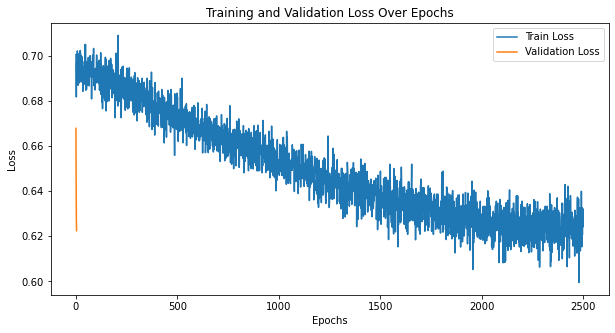

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_history.train_losses, label='Train Loss')
plt.plot(loss_history.eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['labels'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

In [33]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictions, true_labels = get_predictions(model, test_loader, device)

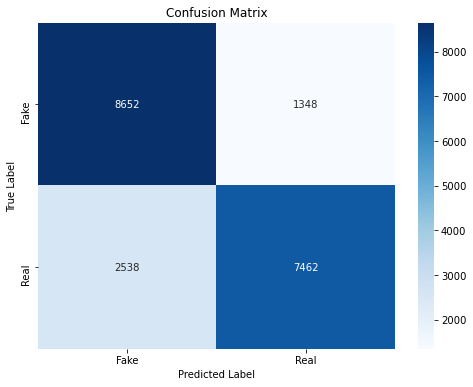

F1 Score: 0.79
Precision: 0.85
Recall: 0.75
Sensitivity: 0.75
Specificity: 0.87


In [35]:
cm = confusion_matrix(true_labels, predictions)
precision, recall, f_score, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display precision, recall, sensitivity, and specificity
print(f"F1 Score: {f_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Predicted Label: REAL


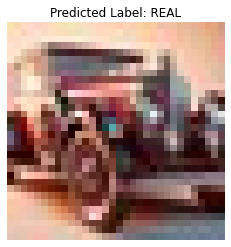

In [47]:
image_path = '1 (2).jpg'
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)
model.eval()
with torch.no_grad():
    outputs = model(pixel_values)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

predicted_label = 'REAL' if predicted_class_idx == 1 else 'FAKE'

print(f"Predicted Label: {predicted_label}")

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

Predicted Label: REAL


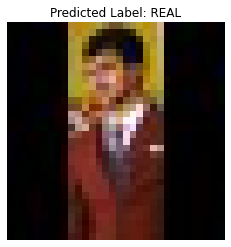

In [43]:
image_path = '4.jpg'
image = Image.open(image_path).convert("RGB")
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs['pixel_values'].to(device)
model.eval()
with torch.no_grad():
    outputs = model(pixel_values)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

predicted_label = 'REAL' if predicted_class_idx == 1 else 'FAKE'

print(f"Predicted Label: {predicted_label}")

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

In [35]:
#trainer.save_model("./outputs/final model")